# Problem Initial
The feedback means a stable daisy population (a
steady state) and the environmental conditions are in a delicate
balance. The code below produces a steady state which arises from a given initial daisy
population,

1.  Add a relatively small (5%, blackconc = 0.05) initial fraction of black daisies to the value in initial.yaml and see what effect this has on the temperature and final daisy populations. Do you still have a final non-zero daisy population?

2. Set the initial black daisy population to 0.05 Attempt to adjust the initial white daisy population to obtain a non-zero steady state. What value of initial white daisy population gives you a non-zero steady state for blackconc=0.05? Do you have to increase or decrease the initial fraction? What is your explanation for this behavior?

3. Experiment with other initial fractions of daisies and look for non-zero steady states. Describe and explain your results. Connect what you see here with the discussion of hysteresis towards the end of this lab - what determines which steady state is reached?

In [43]:
# functions for problem initial
import context
from numlabs.lab5.lab5_funs import Integrator
import numpy as np
from collections import namedtuple


class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi)
        f[1] = y[1] * (beta_b * bare - user.chi)
        return f

Black daisie steady state value =  0.007353178051750249
White daisie steady state value =  0.6452579031671843


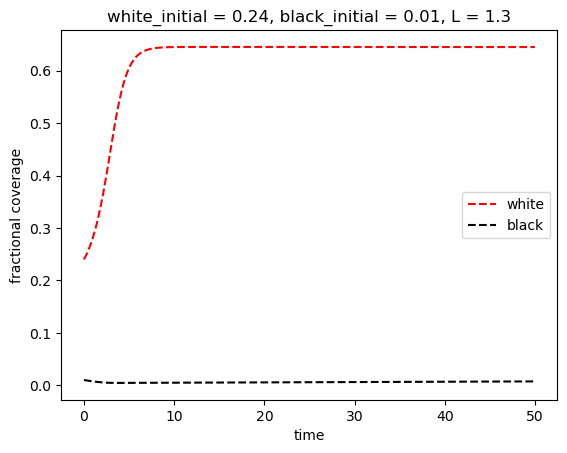

In [44]:
# Solve and plot for problem initial
import matplotlib.pyplot as plt
import pandas as pd

theSolver = Integ54('initial-grace1.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies = pd.DataFrame(yvals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
theAx.set_title('white_initial = ' + str(yvals[0,0]) + ', black_initial = ' + str(yvals[0,1]) + ', L = 1.3')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
print('Black daisie steady state value = ', yvals[-1,1])
print('White daisie steady state value = ', yvals[-1,0])

1. adding 0.05 to the black daisie concentration made both daisy populations decrease drastically. The population is basically zero (black daisy equilibrium is 1.6e-8, and white daisy equilibrium is 2.5e-7)

2. Increasing the initial white daisies by 0.01 allowed the system to have a non-zero daisy population (black daisy eq. = 0.007, white daisy eq. = 0.65). The white daisies have a higher albedo than the black daisies, so increasing the initial fraction of white daisies means that the planet is reflecting more light which decreases the temperature of the planet to one where the daisies can survive.

3. If you keep increasing the white and black daisy initial concentrations by the same amount, they reach the similar equilibriums as q.2. If the initial white daisy concentration is larger enough, it doesn't matter what the initial balck daisy concentration is, the equilibriums will be almost the same for each new black daisy contentration. UNTIL you increase the black daisies enough to make the temp large enough to kill them both. When the diffeence between the initial concentrations is smaller, so is the difference between the equilibrium populations, and a large diff in initial concentration = a larger diff in eq population (but only by a little bit). With all of the initial conditions I tried, the black daisies never increase beyond their initial concentration. This is because the growth rate of the daisies is dependent on the temperature they produced based of their albedo. The black daisies have a lower albedo, giving a higher temperature, and a smaller growth rate. With a daisie death rate of 0.3 (which I used for each iteration of initial concentrations), the black daisy growth rate is negative so the population always gets really small. You have to lower the death rate to 0.1 (from 0.3) to see a positive black daisy growth.

Check how the daisies effect the temperature,

Equilibrium earth temperature =  290.8836298656207


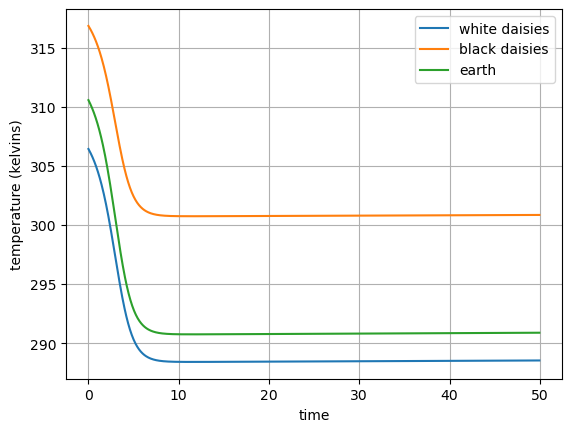

In [45]:
# Solve and plot for problem initial
import matplotlib.pyplot as plt
import pandas as pd

theSolver = Integ54('initial-grace1.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies = pd.DataFrame(yvals, columns=['white', 'black'])
tempSolve =np.zeros(shape=(len(timevals),3))
for i in range(len(timevals)):
    tempSolve[i,:] = theSolver.find_temp(yvals[i])

fig2, ax2 = plt.subplots(1,1)
line1, = ax2.plot(timevals, tempSolve[:,0], label = 'white daisies')
line2, = ax2.plot(timevals, tempSolve[:,1], label = 'black daisies')
line3, = ax2.plot(timevals, tempSolve[:,2], label = 'earth')
ax2.set_ylabel('temperature (kelvins)')
ax2.set_xlabel('time')
#ax2.set_title('blackconc = 0.04')
ax2.legend()
plt.grid()
print('Equilibrium earth temperature = ', tempSolve[-1,2])

# Problem adaptive
The demos in the previous section solved the Daisyworld equations using the embedded Runge-Kutta methods with adaptive timestep control.

1.  Run the code and find solutions of Daisyworld with the default settings found in adapt.yaml using the timeloop5Err adaptive code

2.  Find the solutions again but this time with fixed stepsizes and compare the size of the timesteps and number of the timesteps.

3.  How much faster does the fixed timeloop need to be to give the same performance as the adaptive timeloop for this case?

<a name="sec_steady"></a>



In [46]:
# your import statements
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import time

Number of adaptive time steps (white) =  23
Number of adaptive time steps (black) =  23
Number of fixed time steps (white) =  500
Number of fixed time steps (black) =  500


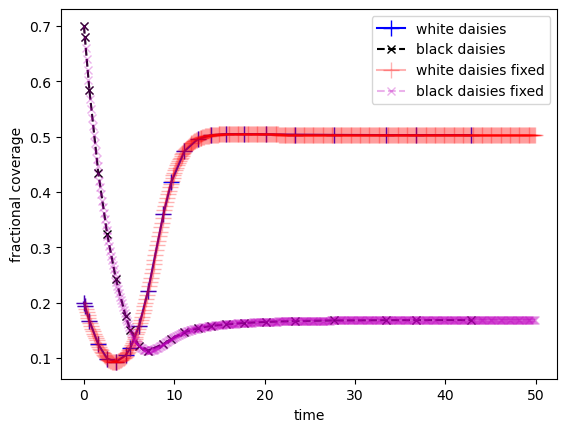

In [47]:
# Solve and plot for adaptive timestep
#start_time = time.time()
theSolver = Integ54('adapt.yaml')
timeVals, yVals, errorList = theSolver.timeloop5Err()

with open('adapt.yaml', 'rb') as f:
    config = yaml.safe_load(f)
    adaptvars_in = namedtuple('adaptvars', config['adaptvars'].keys())
    adaptvars = adaptvars_in(**config['adaptvars'])
    
yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black'])
print('Number of adaptive time steps (white) = ', len(yvals['white']))
print('Number of adaptive time steps (black) = ', len(yvals['black']))
#end_time = time.time()

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(timeVals, yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '--kx', label='black daisies')
#theAx.set_title('adaptive vs fixed timesteps, tolerance = ' + str(adaptvars.rtol))
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

#start_time2 = time.time()
timeVals,yVals,errorList=theSolver.timeloop5fixed()
yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black'])
#end_time2 = time.time()

points, = theAx.plot(timeVals, yvals['white'], '-r+', label='white daisies fixed',alpha=0.3)
print('Number of fixed time steps (white) = ', len(yvals['white']))
print('Number of fixed time steps (black) = ', len(yvals['black']))
points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '--mx', label='black daisies fixed',alpha=0.3)
out = theAx.legend(loc='best')

#perc = (end_time/end_time2) * 100
#print('time to compute with adaptive steps = ', end_time)
#print('time to compute with fixed steps = ', end_time2)
#print('time to compute with adaptive steps - time to compute with fixed steps = ', end_time-end_time2)
#print('the adaptive algorithm took ', ((end_time2-end_time)/end_time)*100, '% less time to compute')

The fixed time step uses 4 calculations per step and used 500 steps in the time interval I gave it. The adaptive algorithm does 6 calculations per step, and used 23 steps. So the fixed time did 2000 calculations to produce this curve, and the adaptive did 138 calculations to produce the same curve. So in this case, the adaptive method was able to find an accurate solution with much less calculations and time than the fixed.

# Problem Predator
To make life a little more interesting on Daisyworld, add a population of rabbits that feed upon the daisies. The
rabbit birth rate will be proportional to the area covered by the daisies while, conversely, the daisy *death rate* will be proportional to the rabbit population.

Add another equation to the Daisyworld model which governs the rabbit population and make the appropriate modifications to the existing daisy equations. Modify the set of equations and solve it with the Runge-Kutta method with adaptive timesteps. Use it to look for steady states and to determine their dependence on the initial conditions and model parameters.

Hand in notebook cells that:

1.  Show your modified Daisyworld equations and your new integrator class.

2.  At least one set of parameter values and initial conditions that leads to the steady state and a plot of the timeseries for the daisies and rabbits.

3.  A discussion of the steady state’s dependence on these values, i.e. what happens when they are altered. Include a few plots for illustration.

4.  Does adding this feedback extend the range of habital L values  for which non-zero populations exist?


Solutions:

1. From the Lab, the rate of change of the white daisies population without rabbits is defined as,
$$
\frac{dA_w}{dt} = A_w ( \beta_w x - \chi)
$$

and the rate of change of the black daisies population without rabbits is,
$$
\frac{dA_b}{dt} = A_b ( \beta_b x - \chi).
$$

With rabbits, the rate of change of the white daisies population is,
$$
\frac{dA_w}{dt} = A_w ( \beta_w x - \chi) - GrazingRate_w
$$

and the rate of change of the black daisies population is,
$$
\frac{dA_b}{dt} = A_b ( \beta_b x - \chi) - GrazingRate_b
$$

where 
$$
GrazingRate_w = C_g * A_r * A_w
$$
$$
GrazingRate_b = C_g * A_r * A_b
$$
($C_g$ is the rabbit grazing rate coefficient).

Then, the rate of change of the rabbit population is,
$$
\frac{dA_r}{dt} = A_r ( RabbitBirthRate * x_r - RabbitDeathRate)
$$

where,
$$
RabbitBirthRate = C_{br}(x_r(A_w + A_b))
$$
$C_{br}$ is the rabbit birth rate coefficient, $x_r$ is the land available for rabbits, and RabbitDeathRate is some constant.

In [48]:
# functions for problem initial
import context
from numlabs.lab5.lab5_funs import Integrator
import numpy as np
from collections import namedtuple


class RabInteg54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rab_i'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rab_i])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=initial rabbits
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        
        #beta is the daisie growth rate
        #chi is the daisie death rate
        #bare is the fractional coverage of the daisies

        rab_i = y[2]
        # rabbits can exist on top of daisies
        barerab = 1.0 - rab_i

        # rabbit birth rate
        rab_br = user.Crbr * (barerab * (y[0] + y[1]))
        
        # rabbit grazing rate 
        wd_graze = user.Crgr * rab_i * y[0]
        bd_graze = user.Crgr * rab_i * y[1]

        # create a 1 x 2 element vector to hold the derivitive
        # the grazing rate is subtracted from the
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi) - wd_graze
        f[1] = y[1] * (beta_b * bare - user.chi) - bd_graze
    
        # add the rabbit population to f
        f[2] = rab_i * (rab_br * barerab - user.rabchi)
        return f

2. 

Black daisie steady state value =  3.763188170988809e-08


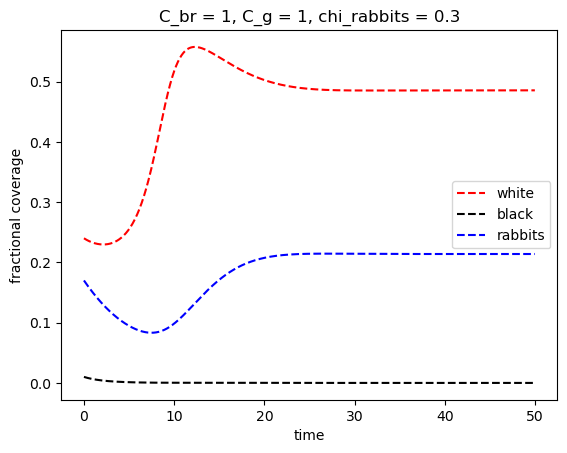

In [49]:
# Solve and plot for problem initial
import matplotlib.pyplot as plt
import pandas as pd

theSolver = RabInteg54('initial-grace1.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbits')
theAx.set_title('C_br = 1, C_g = 1, chi_rabbits = 0.3')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
print('Black daisie steady state value = ', yvals[-1,1])

3. For the first set of initial parameters used in the plot above, the total amount of daisies in Daisyworld is larger than the amount of rabbits but they aren't that much different. The concentration of black daisies is low so the rabbits don't bother them too much and they quickly reach a very small non-zero equilibrium, similar to how they behave with no rabbits. So, the rabbits eat the white daisies and their concentration dips. This results in the rabbit population decreasing because they dont have enough food. Less rabbits then allows the white daisies to start growing quickly, which in turn allows the rabbit population to start growing because there is more food until the daisies dip again and find an equilibrium with the rabbits. 

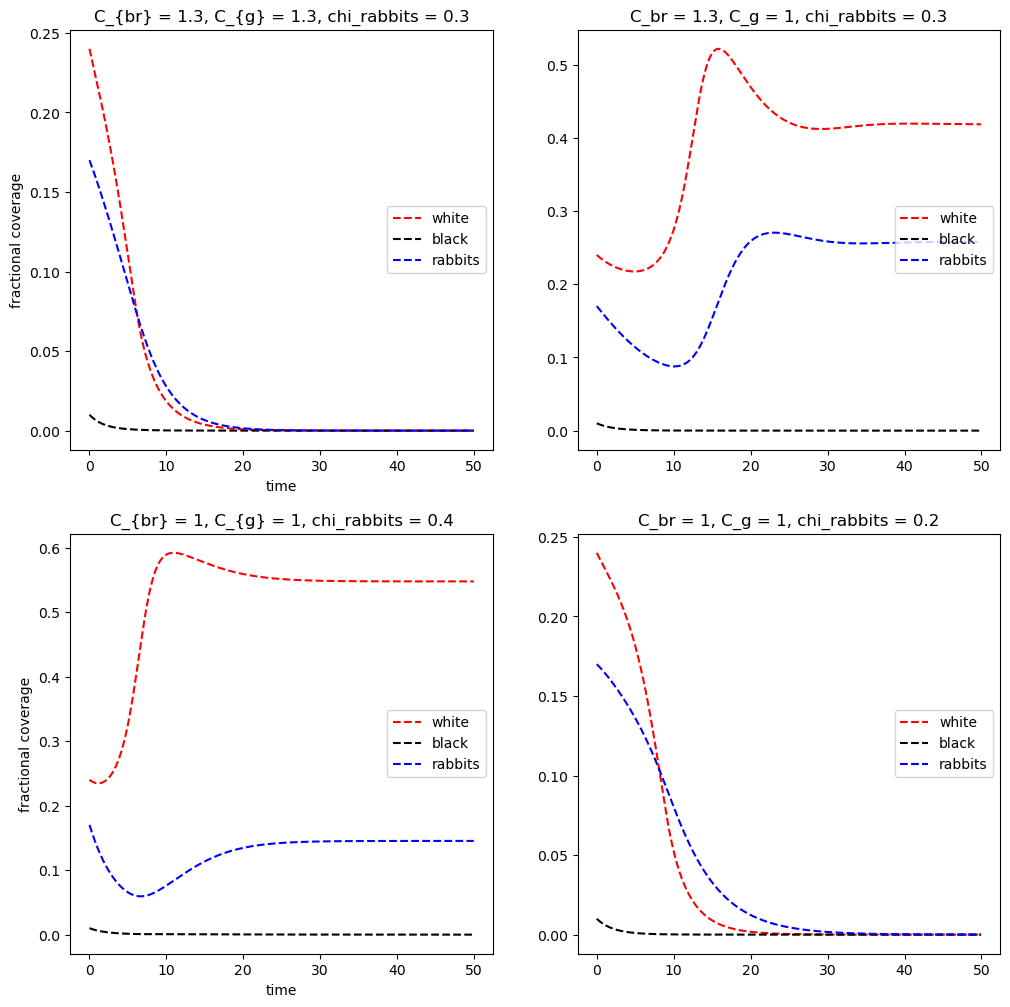

In [50]:
theSolver = RabInteg54('initial-grace2.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies2 = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits'])

thefig, ((ax2,ax3),(ax4,ax5)) = plt.subplots(2, 2, figsize=(12,12))
line4, = ax2.plot(timevals, daisies2['white'])
line5, = ax2.plot(timevals, daisies2['black'])
line6, = ax2.plot(timevals, daisies2['rabbits'])
line4.set(linestyle='--', color='r', label='white')
line5.set(linestyle='--', color='k', label='black')
line6.set(linestyle='--', color='b', label='rabbits')
ax2.set_xlabel('time')
ax2.set_title('C_{br} = 1.3, C_{g} = 1.3, chi_rabbits = 0.3')
ax2.set_ylabel('fractional coverage')
out = ax2.legend(loc='center right')

theSolver = RabInteg54('initial-grace3.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies3 = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits'])

line7, = ax3.plot(timevals, daisies3['white'])
line8, = ax3.plot(timevals, daisies3['black'])
line9, = ax3.plot(timevals, daisies3['rabbits'])
line7.set(linestyle='--', color='r', label='white')
line8.set(linestyle='--', color='k', label='black')
line9.set(linestyle='--', color='b', label='rabbits')
ax3.set_title('C_br = 1.3, C_g = 1, chi_rabbits = 0.3')
out = ax3.legend(loc='center right')


theSolver = RabInteg54('initial-grace4.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies4 = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits'])

line4, = ax4.plot(timevals, daisies4['white'])
line5, = ax4.plot(timevals, daisies4['black'])
line6, = ax4.plot(timevals, daisies4['rabbits'])
line4.set(linestyle='--', color='r', label='white')
line5.set(linestyle='--', color='k', label='black')
line6.set(linestyle='--', color='b', label='rabbits')
ax4.set_xlabel('time')
ax4.set_title('C_{br} = 1, C_{g} = 1, chi_rabbits = 0.4')
ax4.set_ylabel('fractional coverage')
out = ax4.legend(loc='center right')

theSolver = RabInteg54('initial-grace5.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies5 = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits'])

line7, = ax5.plot(timevals, daisies5['white'])
line8, = ax5.plot(timevals, daisies5['black'])
line9, = ax5.plot(timevals, daisies5['rabbits'])
line7.set(linestyle='--', color='r', label='white')
line8.set(linestyle='--', color='k', label='black')
line9.set(linestyle='--', color='b', label='rabbits')
ax5.set_title('C_br = 1, C_g = 1, chi_rabbits = 0.2')
out = ax5.legend(loc='center right')


Now investigation different parameters: Increasing the rabbit birth rate and grazing rate together without adjusting the rabbit death rate kills everything off. 

Increasing just the birth rate by a bit (+ ~0.3) allows the system to find a closer equilibrium but increasing just the grazing rate by the same amount kills everything off.

Increasing the rabbit death rate to be greater than the daisy death rate, with $C_{br}=1$ and $C_{g}=1$ also still allows the system to find an equilibrium but the difference between the size of the white daisie concentration and the rabbit population increases. With the rabbit dying quicker, the white daisies grow quicker, so the rabbits population remains non-zero with the abundance of food but they the population stays small. But, of course, increasing the death rate too much kills the rabbits of quickly and lets the daisies exist how they did before the rabbit were introduced.

Decreasing the rabbit death rate by too much (- ~0.1) to be less than the daisy death rate sends everything towards zero because the rabbits live too long and eat too much so they run out of food. But the equilibrium is still non-zero because eventually the daisies will grow back when the rabbit population is small enough and the tiny rabbit population eats them but neither species population is able to grow big.

$S_0$ is a solar flux density constant, and $L$ is the fraction of $S_0$ received at Daisyworld.. Increasing the L value made the plots above with the various rabbit birth and grazing rates go to zero. So increasing the fraction of the solar flux density on DaisyWorld even by 0.05 increased the temperature too much for anything to live. However, decreasing L allowed for all the plots above to oscilate and find a non-zero equilibrium. For the plot that went to zero with L=1.3 (upper left and lower right), are now finding a non-zero eq. with L<1.3 because a smaller L value, results in a smaller Te value given, $T^4_e = L \frac{S_0}{4\sigma}(1-\alpha_p)$, which decreases the temperature over the white and black daisies, which increases the growth rate. So the increased daisy growth rate counters the smaller rabbit death rate and the larger rabbit grazing and birth rates parameters that are in those plots.